In [1]:
import sys
import os
from scipy import linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
sys.path.append("..")
# Enable interactive plotting in Jupyter Notebook

from utils.detection_utils import *

In [2]:
run_name = "RUN3"
n_stickers = 5
file_number = 10
test_file = "10mm7.mp4"

spiegel_calib = "spiegel.mp4"
front_calib = "front.mp4"
stereo_calib = "stereo.mp4"

In [3]:
calibration_dir = f"../videos/{run_name}/calibration"
detection_dir = f"../videos/{run_name}/detection"
detection_files = os.listdir(detection_dir)
files = os.listdir(f"../videos/{run_name}/detection")
model = YOLO("../weights/best.pt")
if test_file is None:
    test_file = files[file_number]

sC = stereoCamera()
sC.load_from_yaml(f"{run_name}.yaml")
vL = videoLoader()
Dt1 = ballDetector()   
Dt2 = ballDetector()
sDt1 = stickerDetector(n_stickers)
sDt2 = stickerDetector(n_stickers)

print("File= ", test_file)

File=  10mm7.mp4


In [4]:
vL.load_video(f"../videos/{run_name}/detection/{test_file}")
frames = vL[30:-30]
stereo_coords = [[],[]]
sticker_stereo_cords = [[], []]
frame_count = []
for j, frame in enumerate(frames):

    frame1, frame2 = sC(frame)
    preds1 = model(frame1)
    preds2 = model(frame2)
   
    ballcoord1 = Dt1(preds1)
    ballcoord2 = Dt2(preds2)
    stickercoords1 = sDt1(preds1)
    stickercoords2 = sDt2(preds2)
    
    if ballcoord1 is None or ballcoord2 is None or stickercoords1 is None or stickercoords2 is None:
        continue
    if len([k for k in stickercoords1.keys() if k in stickercoords2.keys()]) < 3 :
        continue
    
    stereo_coords[0].append(ballcoord1)
    stereo_coords[1].append(ballcoord2)
    sticker_stereo_cords[0].append(stickercoords1)
    sticker_stereo_cords[1].append(stickercoords2)
    frame_count.append(j)
           

/mnt/Projekte/BallMill3D/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


0: 320x640 1 Ball, 5 Stickers, 278.1ms
Speed: 93.3ms preprocess, 278.1ms inference, 3856.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 Ball, 5 Stickers, 20.0ms
Speed: 1.7ms preprocess, 20.0ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)
Warming up 0
Warming up 0

0: 320x640 1 Ball, 5 Stickers, 20.2ms
Speed: 4.3ms preprocess, 20.2ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 Ball, 5 Stickers, 21.3ms
Speed: 6.1ms preprocess, 21.3ms inference, 2.5ms postprocess per image at shape (1, 3, 320, 640)
Warming up 1
Warming up 1

0: 320x640 1 Ball, 5 Stickers, 20.1ms
Speed: 3.5ms preprocess, 20.1ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 Ball, 5 Stickers, 20.2ms
Speed: 1.9ms preprocess, 20.2ms inference, 2.5ms postprocess per image at shape (1, 3, 320, 640)
Warming up 2
Warming up 2

0: 320x640 1 Ball, 5 Stickers, 20.2ms
Speed: 2.8ms preprocess, 20.2ms inference, 3.1ms postprocess p

In [5]:
print(np.array(stereo_coords).shape)
print(len(frame_count))    

(2, 434, 2)
434


In [6]:
def DLT(P1, P2, point1, point2):
        A = [point1[1] * P1[2, :] - P1[1, :],
             P1[0, :] - point1[0] * P1[2, :],
             point2[1] * P2[2, :] - P2[1, :],
             P2[0, :] - point2[0] * P2[2, :]
             ]
        A = np.array(A).reshape((4, 4))
        B = A.transpose() @ A
        U, s, Vh = linalg.svd(B, full_matrices=False)

        return Vh[3, 0:3] / Vh[3, 3]

def triangulate(SC, point1, point2):
    RT1 = np.concatenate([np.eye(3), [[0], [0], [0]]], axis=-1)
    RT2 = np.concatenate([SC.conf["rotation_matrix"][0], SC.conf["translation_matrix"][0]], axis=-1)

    P1 = SC.conf["camera_matrix"][0] @ RT1
    P2 = SC.conf["camera_matrix"][1] @ RT2

    coordinate = DLT(P1, P2, point1, point2)
    return coordinate

In [7]:
def compute_transform_matrix(points_A, points_B):
    """Calculates the transform matrix to transform any point of one coordinatesystem (3d) to another"""
    # Assuming points_A and points_B are numpy arrays with shape (N, 3)
    # where N is the number of points (N >= 3),
    # Reshaping the points
    points_A = np.array(points_A)
    points_B = np.array(points_B)
    points_A = points_A.T
    points_B = points_B.T

    # Calculate the centroids of both point sets
    centroid_A = np.mean(points_A, axis=1, keepdims=True)
    centroid_B = np.mean(points_B, axis=1, keepdims=True)

    # Compute the centered point sets
    centered_A = points_A - centroid_A
    centered_B = points_B - centroid_B

    # Compute the covariance matrix
    covariance_matrix = centered_A @ centered_B.T

    # Perform Singular Value Decomposition
    U, _, Vt = np.linalg.svd(covariance_matrix)

    # Calculate the rotation matrix
    rotation_matrix = Vt.T @ U.T

    # Calculate the translation vector
    translation_vector = centroid_B - rotation_matrix @ centroid_A

    # Create the transformation matrix
    transform_matrix = np.eye(4)
    transform_matrix[:3, :3] = rotation_matrix
    transform_matrix[:3, 3] = translation_vector.flatten()
    return transform_matrix

def transform_point(point, transform_matrix):
    """Transforms a point to a nother coordinate system (3d) based on a transform_matrix"""
    # point needs one extra dimension
    point = np.array([point])
    point_homogeneous = np.hstack((point, np.ones((1, 1))))
    new_point_homogeneous = transform_matrix @ point_homogeneous.T

    # Extract the transformed point in system B
    new_point = new_point_homogeneous[:3, :].T
    return new_point[0]

# Calculating the 3D Points

In [8]:
ball3d = [triangulate(sC, point1, point2) for point1, point2 in zip(stereo_coords[0], stereo_coords[1])]
sticker3d = []

for sticker_coords1, sticker_coords2 in zip(*sticker_stereo_cords):
    valid_points = [k for k in sticker_coords1.keys() & sticker_coords2.keys()]
    points = {k: triangulate(sC, sticker_coords1[k], sticker_coords2[k]) for k in valid_points}
    sticker3d.append(points)

In [13]:
# Removing the yar movement

fixedball3d = [ball3d[0]]
base_sticker_points = sticker3d[0]
fixedsticker3d = [[v for v in base_sticker_points.values()]]

for ball_point, sticker_points, in zip(ball3d[1:], sticker3d[1:]):
    valid_points = [k for k in base_sticker_points.keys() & sticker_points.keys()]
    transform_matrix = compute_transform_matrix([sticker_points[k] for k in valid_points], [base_sticker_points[k] for k in valid_points])
    ball_point_new = transform_point(ball_point, transform_matrix)
    sticker_point_new = transform_point(sticker_points[0], transform_matrix)
    #print("Diff", ball_point -ball_point_new)
    print("Stickerpoint diff", base_sticker_points[0] -sticker_point_new)
    fixedball3d.append(ball_point_new)
    fixedsticker3d.append([transform_point(p, transform_matrix) for p in sticker_points.values()])
    

Stickerpoint diff [-3.6979e-05  1.1019e-05  -5.588e-05]
Stickerpoint diff [ 6.7749e-05 -2.6231e-05  6.5169e-05]
Stickerpoint diff [-0.00010332 -4.7441e-05 -4.0162e-05]
Stickerpoint diff [-0.00020327 -7.8332e-05 -4.3325e-05]
Stickerpoint diff [-0.00029728 -7.0526e-05 -0.00012298]
Stickerpoint diff [-0.00060081 -0.00010166  -0.0002729]
Stickerpoint diff [-0.00074251 -0.00013544 -0.00035373]
Stickerpoint diff [ -0.0010704 -0.00020415 -0.00061886]
Stickerpoint diff [ -0.0012083 -0.00024056  -0.0006591]
Stickerpoint diff [ -0.0013711 -0.00027245 -0.00073615]
Stickerpoint diff [ -0.0015064 -0.00029376  -0.0007242]
Stickerpoint diff [ -0.0015684 -0.00027175 -0.00079612]
Stickerpoint diff [ -0.0017352 -0.00028869 -0.00090501]
Stickerpoint diff [ -0.0018074 -0.00028437 -0.00095234]
Stickerpoint diff [  -0.001807 -0.00027443 -0.00099216]
Stickerpoint diff [ -0.0018583 -0.00028337 -0.00099945]
Stickerpoint diff [  -0.001894 -0.00031344  -0.0010555]
Stickerpoint diff [ -0.0018922 -0.00029956  -0.0

(2604, 3)


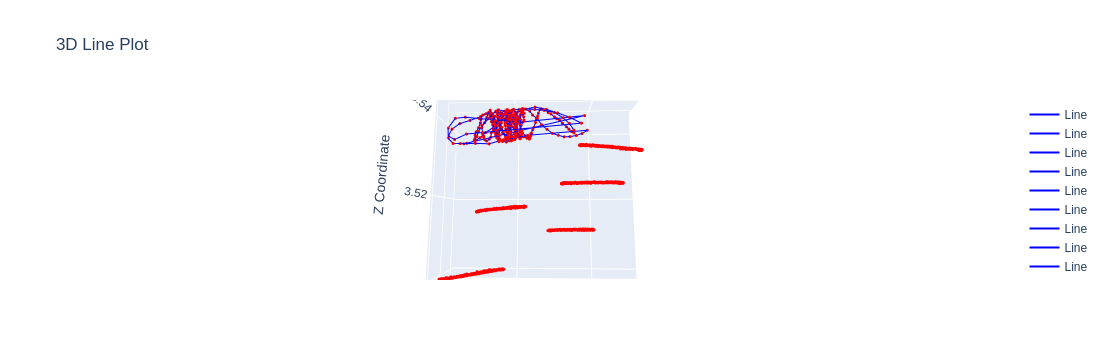

In [58]:

coords = np.array(ball3d)  # Update this line based on your actual data
coords_sticker = np.array([x for p in sticker3d for x in p.values()])
# Create line connections between sequential points
connections = [[a, b] for a, b in zip(range(len(coords)-1), range(1, len(coords)))]
coords = np.concatenate([coords, coords_sticker], 0)
print(coords.shape)
# Calculate max range to set equal axes
x_range = [coords[:, 0].min(), coords[:, 0].max()]
y_range = [coords[:, 1].min(), coords[:, 1].max()]
z_range = [coords[:, 2].min(), coords[:, 2].max()]

# Find the maximum range
max_range = max(x_range[1] - x_range[0], y_range[1] - y_range[0], z_range[1] - z_range[0])

# Calculate the mid points for each axis
x_mid = sum(x_range) / 2
y_mid = sum(y_range) / 2
z_mid = sum(z_range) / 2

# Set the range for each axis to be the max range centered around the mid point
x_range = [x_mid - max_range / 2, x_mid + max_range / 2]
y_range = [y_mid - max_range / 2, y_mid + max_range / 2]
z_range = [z_mid - max_range / 2, z_mid + max_range / 2]

# Create the figure object
fig = go.Figure()

# Add lines between connected points
for conn in connections:
    fig.add_trace(go.Scatter3d(
        x=[coords[conn[0], 0], coords[conn[1], 0]],
        y=[coords[conn[0], 1], coords[conn[1], 1]],
        z=[coords[conn[0], 2], coords[conn[1], 2]],
        mode='lines',
        line=dict(color='blue', width=2),
        name='Line'
    ))

# Add markers for each point
fig.add_trace(go.Scatter3d(
    x=coords[:, 0],
    y=coords[:, 1],
    z=coords[:, 2],
    mode='markers',
    marker=dict(size=1, color='red'),
    name='Points'
))

# Update plot appearance
fig.update_layout(
    title="3D Line Plot",
    scene=dict(
        xaxis_title='X Coordinate',
        yaxis_title='Y Coordinate',
        zaxis_title='Z Coordinate',
        xaxis=dict(range=x_range, autorange=False),
        yaxis=dict(range=y_range, autorange=False),
        zaxis=dict(range=z_range, autorange=False),
        aspectmode='manual'
        #,
        #aspectratio=dict(x=1, y=1, z=1)
    )
)

# Show the plot
fig.show()

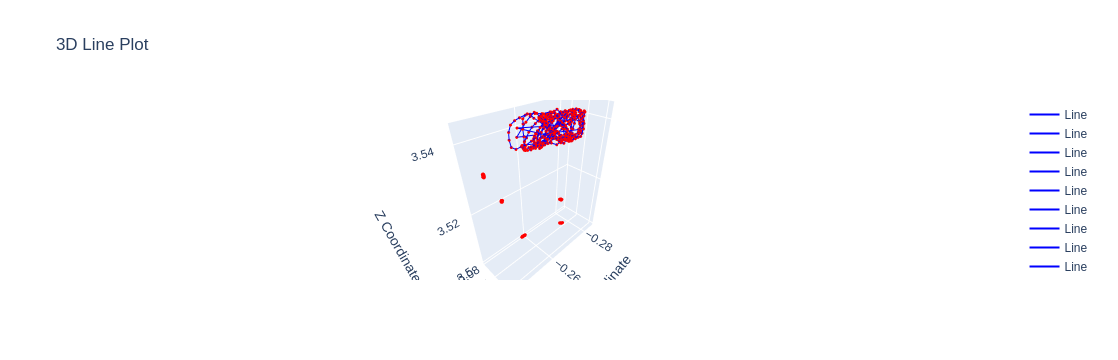

In [17]:
coords = np.array(fixedball3d)  # Update this line based on your actual data
coords_sticker = np.array([x for p in fixedsticker3d for x in p])

# Create line connections between sequential points
connections = [[a, b] for a, b in zip(range(len(coords)-1), range(1, len(coords)))]
coords = np.concatenate([coords, coords_sticker], 0)
# Calculate max range to set equal axes
x_range = [coords[:, 0].min(), coords[:, 0].max()]
y_range = [coords[:, 1].min(), coords[:, 1].max()]
z_range = [coords[:, 2].min(), coords[:, 2].max()]

# Find the maximum range
max_range = max(x_range[1] - x_range[0], y_range[1] - y_range[0], z_range[1] - z_range[0])

# Calculate the mid points for each axis
x_mid = sum(x_range) / 2
y_mid = sum(y_range) / 2
z_mid = sum(z_range) / 2

# Set the range for each axis to be the max range centered around the mid point
x_range = [x_mid - max_range / 2, x_mid + max_range / 2]
y_range = [y_mid - max_range / 2, y_mid + max_range / 2]
z_range = [z_mid - max_range / 2, z_mid + max_range / 2]

# Create the figure object
fig = go.Figure()

# Add lines between connected points
for conn in connections:
    fig.add_trace(go.Scatter3d(
        x=[coords[conn[0], 0], coords[conn[1], 0]],
        y=[coords[conn[0], 1], coords[conn[1], 1]],
        z=[coords[conn[0], 2], coords[conn[1], 2]],
        mode='lines',
        line=dict(color='blue', width=2),
        name='Line'
    ))

# Add markers for each point
fig.add_trace(go.Scatter3d(
    x=coords[:, 0],
    y=coords[:, 1],
    z=coords[:, 2],
    mode='markers',
    marker=dict(size=1, color='red'),
    name='Points'
))

# Update plot appearance
fig.update_layout(
    title="3D Line Plot",
    scene=dict(
        xaxis_title='X Coordinate',
        yaxis_title='Y Coordinate',
        zaxis_title='Z Coordinate',
        xaxis=dict(range=x_range, autorange=False),
        yaxis=dict(range=y_range, autorange=False),
        zaxis=dict(range=z_range, autorange=False),
        aspectmode='manual'
        #,
        #aspectratio=dict(x=1, y=1, z=1)
    )
)

# Show the plot
fig.show()

# testing stereo vision results 


-0.27737493889412956 -0.2415031580767144
-0.06107664554937043 -0.05823822388493083
3.534718559715113 3.5449712189935347


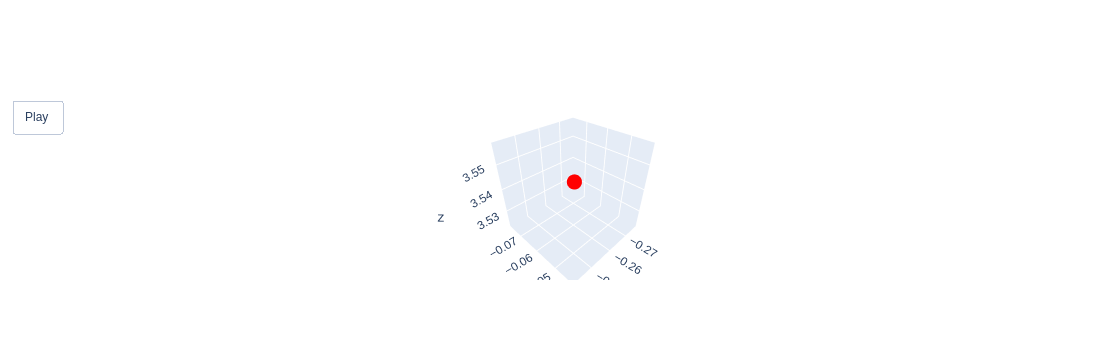

In [41]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np

coords = np.array(coords3d[0][:])  # Update this line based on your actual data

# Create line connections between sequential points
connections = [[a, b] for a, b in zip(range(len(coords)-1), range(1, len(coords)))]

# Calculate max range to set equal axes
x_range = [coords[:, 0].min(), coords[:, 0].max()]
y_range = [coords[:, 1].min(), coords[:, 1].max()]
z_range = [coords[:, 2].min(), coords[:, 2].max()]

# Find the maximum range
max_range = max(x_range[1] - x_range[0], y_range[1] - y_range[0], z_range[1] - z_range[0])

# Calculate the mid points for each axis
x_mid = sum(x_range) / 2
y_mid = sum(y_range) / 2
z_mid = sum(z_range) / 2

# Set the range for each axis to be the max range centered around the mid point
x_range = [x_mid - max_range / 2, x_mid + max_range / 2]
y_range = [y_mid - max_range / 2, y_mid + max_range / 2]
z_range = [z_mid - max_range / 2, z_mid + max_range / 2]
frame_numbers = np.array(frame_counts[0])
frame_numbers -= frame_numbers[0]

# Calculate total frames for 30 fps over the maximum frame index
total_frames = max(frame_numbers) + 1  # subtracting warmupsteps

# Create interpolated coordinates array
interpolated_coords = np.zeros((total_frames, 3))


for i in range(len(frame_numbers) - 1):
    start_frame, end_frame = frame_numbers[i], frame_numbers[i + 1]
    start_coords, end_coords = coords[i], coords[i + 1]
    for frame in range(start_frame, end_frame + 1):
        #print(frame, (1 - t) * start_coords + t * end_coords)
        t = (frame - start_frame) / (end_frame - start_frame)
        interpolated_coords[frame] = (1 - t) * start_coords + t * end_coords


print(interpolated_coords[:,0].min(), interpolated_coords[:,0].max())
print(interpolated_coords[:,1].min(), interpolated_coords[:,1].max())
print(interpolated_coords[:,2].min(), interpolated_coords[:,2].max())

# Using the interpolated coordinates for the animation
fig = go.Figure(
    data=[go.Scatter3d(
        x=[interpolated_coords[0, 0]], 
        y=[interpolated_coords[0, 1]], 
        z=[interpolated_coords[0, 2]],
        mode='markers',
        marker=dict(size=5, color='red')  # Adjust the size for visibility
    )],
    layout=go.Layout(
        scene=dict(
            xaxis=dict(range=[x_range[0], x_range[1]]),
            yaxis=dict(range=[y_range[0], y_range[1]]),
            zaxis=dict(range=[z_range[0], z_range[1]]),
            aspectmode='cube'  # Ensures all axes have the same scale
        ),
        updatemenus=[dict(
            type='buttons',
            showactive=False,
            buttons=[{'label': 'Play',
                      'method': 'animate',
                      'args': [None, {"frame": {"duration": 50, "redraw": True},
                                      "fromcurrent": True, "transition": {"duration": 30, "easing": "linear"}}]}]
        )]
    ),
    frames=[
        go.Frame(data=[go.Scatter3d(
            x=[coord[0]], y=[coord[1]], z=[coord[2]],
            mode='markers',
            marker=dict(size=5, color='red')  # Adjust the size to maintain the diameter of the ball
        )]) for coord in interpolated_coords
    ]
)

fig.show()

In [20]:
coords3d


array([   -0.26133,   -0.060881,      3.5419])